# Alineamiento y centrado de la imagen



El sistema puede estar mal alineado. Eso se comprueba obteniendo una imagen y desplazando el motor. Si la imagen se desplaza horizontal o verticalmente cuando se desplaza la cámara, está mal alineado. 
Posteriormente, se comprueba si la imagen está centrada y cómo hacerlo en caso negativo. 

by: Joaquín Andrés Porras

## Cargar Módulos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY

from py_lab.camera import Camera
from py_lab.motor import Motor
from py_lab.slm import SLM
from py_lab.utils import List_COM_Ports


number of processors: 8
total memory        : 15.9 Gb
available memory    : 71 %
max frequency       : 3501 GHz


In [3]:
np

<module 'numpy' from 'C:\\Users\\Laboratorio\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\numpy\\__init__.py'>

In [3]:
from numpy import pi

In [4]:
import time
import cv2
import serial
import serial.tools.list_ports
import screeninfo
import matplotlib

# Camara
ms=1.
seconds=1000*ms

# Motores
s = 1

%matplotlib qt
%matplotlib inline

## Primer paso: Controlar la cámara, el motor y el modulador. 

Encendemos la cámara, el motor y el modulador y los activamos para que sea Python el que los controle. 
Comenzamos con la cámara, y tomamos una imagen para comprobar que funciona. 

In [5]:
# Cámara
cam = Camera(name="ImagingSource") 
devices = cam.List_Devices(verbose=True)
cam.Open()
cam.Set_Property("Resolution", "Y800 (1024x768)")
# Framerate
cam.Set_Property("FrameRate", 5)
# Otros parametros
cam.Set_Property("Gain", 0, is_switcher=True)
cam.Set_Property("Gain", 2)
#Aquí podemos variar el tiempo de exposición de la cámara. 
value=int(np.log2(1/2000.))
print(value)
cam.Set_Property("Exposure", value)
cam.Start_Live() 


0 : b'DMx 72BUC02 14210300'



-10



In [6]:
cam.Set_Property("Gain", 3)
#Aquí podemos variar el tiempo de exposición de la cámara. 
cam.Set_Property("Exposure", -10)

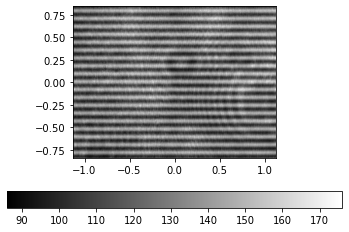

In [7]:
# Comprobamos que se obtiene una imagen. 
image = cam.Get_Image(draw=True)

In [11]:
cam.Close()

Ahora toca manejar el motor: 

In [5]:
motor = Motor(name='SMC100')
motor.Open(port='COM3')
motor.Test_Connection()

Connecting to SMC100 on COM3
Found stage ILS250PP_PN:B0921669954252_UD:091029
Stage SMC100 ready


In [6]:
#El Home es una función inicial para despazar el motor a un punto concreto fijo, el 0 de su sistema. 
motor.Home()

Por último. queda el uso del modulador: 

In [7]:
slm = SLM(name="HoloEye2500", M=1)

# Segundo paso: creación de una imagen a partir de una máscara. 
A continuación, obtenemos una imagen a partir de una máscara. Como ejemplo, usamos un sistema de ajedrezado en dos dimensiones. 

Si no se observa una imagen en la pantalla, se debe a que el haz del láser no está incidiendo sobre la cámara. Solución: hay que desplazar vertical y horizontalmente la cámara hasta que se observe la imagen. 

La imagen se puede observar en una ventana que Python crea con la imagen de la cámara en tiempo real.

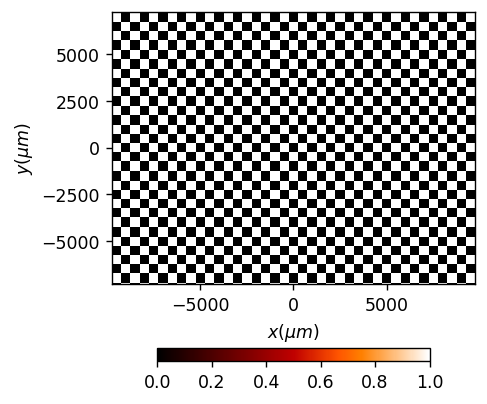

In [8]:
mask = Scalar_mask_XY(x=slm.x, y=slm.y, wavelength=slm.wavelength)
mask.grating_2D_chess(period=1000.0 * um, amin=0, amax=1., phase=0. * pi / 2, r0=[0,0], fill_factor=0.5, angle=0.0 * degrees)
mask.draw(kind='intensity', has_colorbar='horizontal')
slm.Send_Image(mask, norm=1, kind='intensity')

# Tercer paso: movimiento del motor
Con la imagen obtenida, se realiza un desplazamiento constante de la cámara generado por el motor. Como se decía previamente, si la imagen (que se puede observar en una ventana que crea Python con la imagen en tiempo real) se desplaza a medida que se desplaza la cámara, el sistema no está alineado, y entonces: 

- Hay que comprobar que el sistema de lentes que amplía la imagen está correctamente situado. 
- Hay que desplazar un tornillo del divisor del haz láser, debido a que está ligeramente desviado de su correcta posición. 

Una vez se vaya moviendo el motor y desplazando el tornillo, en cuanto se deje de ver movimiento de la imagen, el sistema estará alineado. 

In [17]:
motor.Move_Absolute(pos=120.0,units='mm', verbose=True, move_time=None)


SMC100WaitTimedOutException: Wait timed out

In [20]:
#Para mover el motor, fijamos una velocidad y una posición absoluta, entre -125 Y 125 ("pos"). 
motor.Set_Velocity(vel=15, units='mm/s')

for i in range(5):
    motor.Move_Absolute(pos=-125,units='mm', verbose=True, move_time=None)
    motor.Move_Absolute(pos=125,units='mm', verbose=True, move_time=None)


SMC100WaitTimedOutException: Wait timed out

In [32]:
motor.Set_Velocity(vel=25, units='mm/s')
motor.Move_Absolute(pos=110,units='mm', verbose=True, move_time=None)


110.0

# Cuarto paso: centrar la imagen
Una vez el sistema esté alineado, se cambia la imagen del ajedrezado por la imagen generada por un agujero o disco. De esta manera, se generan círculos en vez de un tablero de ajedrez. Con esta imagen, se puede desplazar la cámara horizontal y verticalmente hasta que el centro de las circunferencias de la imagen esté en el centro de la cámara. 

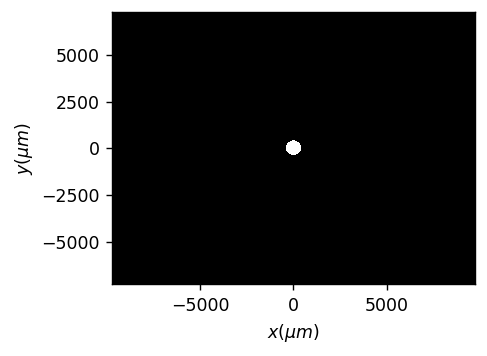

In [13]:
mask.circle(r0=(0,0), radius=400, angle=0)
mask.draw(kind='intensity')
slm.Send_Image(mask, norm=1, kind='intensity')

(-1.1264, 1.1264, -0.8448, 0.8448)

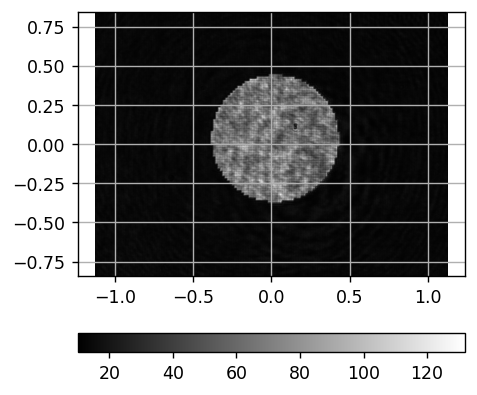

In [45]:
# Comprobamos que se obtiene una imagen. 
image = cam.Get_Image(draw=True)
plt.grid('on')
plt.axis('equal')

# Sistema centrado y alineado
Cuando se hayan seguido todos los pasos, entonces se puede afirmar que el sistema está alineado y centrado. 
Se añaden a continuación código de programación para cerrar la cámara, el motor y el modulador. 

In [22]:
slm.Close_All_Images()
motor.Close()
cam.Stop_Live()